In [85]:
import os
import math
import datetime
import numpy as np
import pandas as pd
from math import pi
import scipy.integrate as spi
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# 1. Define Functions

In [59]:
# get data in time range required
def get_data_range(data, time, start, end):
        return [d for t, d in zip(time, data) if start <= t <= end]

In [60]:
# detect sharp data spikes and clean data
def remove_spike_points(data, threshold, window_size):
    spike_points = []
    
    for i in range(window_size, len(data) - 1):
        window = data[i - window_size:i]
        mean_diff = np.mean(np.diff(window))
        if mean_diff >= threshold:
            spike_points.append(i - 1)
            
    data[spike_points] = 0
    
    return data

In [215]:
# find filling start time using tank pressure gradual increase detection
def find_fill_start_time(p_tank, time, target_pressure, pressure_change_threshold, start_time_buffer):
    crossing_indices = np.where(p_tank >= target_pressure)[0]  
    initial_crossing_index = crossing_indices[0]
    initial_crossing_time = time[initial_crossing_index]
    gradual_increasing_indices = np.where(p_tank - p_tank[initial_crossing_index] >= pressure_change_threshold)[0]
    gradual_increasing_index = gradual_increasing_indices[0]
    time_reach_gradual_increase = time[gradual_increasing_index]
    start_time_fill = time_reach_gradual_increase - start_time_buffer
    
    return start_time_fill

In [216]:
# get burn_time starting at peak thrust index. Assuming burn time ends when thrust goes below threshold after peak (can adjust threshold)
def calculate_burn_time(time_range, thrust_range, peak_index, thrust_end_threshold):
    peak_index = np.argmax(thrust_range)
    peak_time = time_range[peak_index]
    thrust_after_peak = thrust_range[peak_index + 1:]
    time_after_peak = time_range[peak_index + 1:]
    
    for burn_end_t, thrust_value in zip(time_after_peak, thrust_after_peak):
        if thrust_value < thrust_end_threshold:
            return burn_end_t - peak_time

In [217]:
# calculate total impulse by numerically integrating the thrust values with respect to time
def calculate_total_impulse(time, thrust):
    def integrand(t):
        return np.interp(t, time, thrust)
    total_impulse = 0
    for i in range(len(time) - 1):
        total_impulse += spi.quad(integrand, time[i], time[i+1])[0]
    return total_impulse

In [218]:
# determine nitrous vapour pressure, liquid density and gas density given temperature
def nitrous_equations(temp_kelvin):
    ## variables
    p_c = 7251          # kPa
    T_c = 309.57        # Kelvin
    rho_c = 452         # kg/m^3

    # 4.1 constants
    b1 = -6.71893
    b2 = 1.35966
    b3 = -1.3779
    b4 = -4.051

    # 4.2 constants
    b1_l = 1.72328
    b2_l = -0.83950
    b3_l = 0.51060
    b4_l = -0.10412

    # 4.3 constants
    b1_g = -1.00900
    b2_g = -6.28792
    b3_g = 7.50332
    b4_g = -7.90463
    b5_g = 0.629427
    
    T_r = temp_kelvin/T_c
    
    # 4.1 Vapour Pressure
    p = p_c * math.exp((1/T_r) * ((b1 * (1-T_r)) + (b2 * (1-T_r)**(3/2)) + (b3 * (1-T_r)**(5/2)) + (b4 * (1-T_r)**5)))
    
    # 4.2 Density of Saturated Liquid
    p_l = rho_c * math.exp((b1_l * (1-T_r)**(1/3)) + (b2_l * (1-T_r)**(2/3)) + (b3_l * (1-T_r)) + (b4_l * (1-T_r)**(4/3)))
    
    # 4.3 Density of Saturated Gas
    p_g = rho_c * math.exp((b1_g * ((1/T_r)-1)**(1/3)) + (b2_g * ((1/T_r)-1)**(2/3)) + (b3_g * ((1/T_r)-1)) + (b4_g * ((1/T_r)-1)**(4/3)) + (b5_g * ((1/T_r)-1)**(5/3)))
    
    return p, p_l, p_g

In [219]:
# turn nitrous vapour pressure, liquid density and gas density into lists
def nitrous_equation_lists(temp_list):
    vap_list = []
    liquid_list = []
    gas_list = []
    for temp_kelvin in temp_list:
        p, p_l, p_g = nitrous_equations(temp_kelvin)
        vap_list.append(p)
        liquid_list.append(p_l)
        gas_list.append(p_g)
        
    return vap_list, liquid_list, gas_list

In [220]:
# estimate liquid and gaseous mass at max given known ambient temperature and diptube length
def calculate_nitrous_mass(outside_temp, diptube_length):
    ## tank dimensions
    outer_radius = 0.09                                           # m
    inner_radius = 0.08268                                        # m
    cyl_height = 0.685                                            # m
    V_total = 0.016                                               # m^3 
    V_inner_cyl = np.pi * (inner_radius**2) * cyl_height          # m^3
    V_inner_hem = V_total - V_inner_cyl                           # m^3
    
    p, p_liq, p_gas = nitrous_equations(outside_temp + 273.15)           # get pressure and density values given known temperature
    V_cyl_liq_ratio = 1 - (diptube_length / cyl_height)         # get percentage of volume in cylinder taken by liquid given ullage height
    V_hem_ratio = V_inner_hem/V_total                            # get percentage of volume taken by hemisphere
    V_liq_ratio = V_cyl_liq_ratio + V_hem_ratio                  # get volume of liquid in tank ratio
    V_liq = V_liq_ratio * V_total                                # get volume of liquid
    V_gas = V_total - V_liq                                      # get volume of gas
    m_liq = round(V_liq * p_liq, 3)                              # get mass of liquid in tank
    m_gas = round(V_gas * p_gas, 3)                              # get mass of gas in tank
    
    return m_liq, m_gas

In [238]:
# create dictionary of nitrous liquid density and temperature values (as solving for liquid density from temp is too mathematically intensive)
temp_list = np.linspace(183, 309, num = 10000)
vap_list, liquid_list, gas_list = nitrous_equation_lists(temp_list)
temp_liquid_density_dict = dict(zip(temp_list, liquid_list))


# Determine liquid density from temperature. Finds key from closest value in dictionary using list comprehension
def get_liquid_density_from_temp(temp_liquid_density_dict, temp_key):
    liquid_density = temp_liquid_density_dict.get(temp_key) or temp_liquid_density_dict[min(temp_liquid_density_dict.keys(), key = lambda key: abs(key-temp_key))]
    
    return liquid_density

# estimate mass flow rate
def calculate_mass_flow_rate(discharge_coeff, hole_diameter, num_holes, p_run_range, p_cc_new_range, run_temp_range, delta_p_run_cc, temp_liquid_density_dict):
    injection_area = (np.pi * ((hole_diameter/1000)/2)**2)
    K = 1 / (0.65**2)
    d_loss = K / ((num_holes * injection_area)**2)
    
    mass_flow_rate = []
    
    for i in range(len(p_run_range)):
        liquid_density = get_liquid_density_from_temp(temp_liquid_density_dict, run_temp_range[i] + 273.15)
        n_o = np.sqrt((2*liquid_density*delta_p_run_cc[i]*6892.76)/d_loss)
        mass_flow_rate.append(n_o)
        
    return mass_flow_rate

In [241]:
# extract data and calculate summary table values
def extract_data(file_name, outside_temp, diptube_length, discharge_coeff, hole_diameter, num_holes):
    # read file as dataframe
    column_names = ['time_ms', 'run_pressure_V', 'fill_pressure_V', 'purge_pressure_V', 'tank_pressure_V', 'tank_mass_V', 'thrust_V', 'cc_pressure_V', 'tank_temp_V', 'run_temp_V', 'vent_temp_V', 'garbage', 'run_pressure_sw', 'fill_pressure_sw', 'purge_pressure_sw', 'tank_pressure_sw', 'tank_mass_sw', 'thrust_sw', 'cc_pressure_sw', 'run_temp_sw', 'tank_temp_sw', 'ven_temp_sw']
    df = pd.read_csv(file_name, sep='\t', names=column_names, index_col=False, dtype=np.float64, skip_blank_lines=True)
    time, p_fill, p_tank, p_run, p_cc, tank_temp, run_temp, tank_mass, thrust, mass = (df['time_ms'] / 1000, df['fill_pressure_sw'], df['tank_pressure_sw'], df['run_pressure_sw'], df['cc_pressure_sw'], df['tank_temp_sw'], df['run_temp_sw'], df['tank_mass_sw'], df['thrust_sw'], df['tank_mass_sw'])
    
    # find hotfire start and end time using peak thrust
    peak_index = np.argmax(thrust)
    peak_time = time[peak_index]
    start_time = int(peak_time) - 1  # assuming start_time is 1 second before peak
    end_time = start_time + 25   # assuming end_time for plots is 25 seconds after start_time
    
    # combustion chamber processing
    p_cc_new = [(i - p_cc[start_time]) * 0.19 for i in p_cc]
    
    # filter out data spikes assuming spike threshold of 5 and window size of 50
    p_tank = remove_spike_points(p_tank, 5, 50)
    
    # find filling start time and end time using tank pressure
    start_time_fill = find_fill_start_time(p_tank, time, 200, 1, 20)
    end_time_fill = start_time
    
    # get time ranges
    time_range = [t - start_time for t in time[(time >= start_time) & (time <= end_time)]]
    time_range_fill = [t for t in time if start_time_fill <= t <= end_time_fill]
    time_range_full = [t - start_time_fill for t in time[(time >= start_time_fill) & (time <= end_time)]]
    
    # get data ranges in time frame
    p_fill_range = get_data_range(p_fill, time, start_time_fill, end_time_fill)
    p_tank_fill_range = get_data_range(p_tank, time, start_time_fill, end_time_fill)
    p_tank_range = get_data_range(p_tank, time, start_time, end_time)
    p_run_range = get_data_range(p_run, time, start_time, end_time)
    p_cc_new_range = get_data_range(p_cc_new, time, start_time, end_time)
    tank_temp_range = get_data_range(tank_temp, time, start_time, end_time)
    run_temp_range = get_data_range(run_temp, time, start_time, end_time)
    thrust_range = get_data_range(thrust, time, start_time, end_time)
    mass_range = get_data_range(mass, time, start_time_fill, end_time)
    
    # calculate pressure deltas
    delta_p_tank_fill = [pt - pf for pt, pf in zip(p_tank_fill_range, p_fill_range)]
    delta_p_tank_run = [pt - pr for pt, pr in zip(p_tank_range, p_run_range)]
    delta_p_run_cc = [pr - pc for pr, pc in zip(p_run_range, p_cc_new_range)]
    
    # calculate mass flow rate
    mass_flow_rate = calculate_mass_flow_rate(discharge_coeff, hole_diameter, num_holes, p_run_range, p_cc_new_range, run_temp_range, delta_p_run_cc, temp_liquid_density_dict)
    
    # summary results
    fill_time = int(time_range_fill[-1] - time_range_fill[0]) # Fill time
    peak_run_pressure = int(max(p_run_range)) # peak run pressure
    peak_cc_pressure = int(max(p_cc_new_range)) # peak cc pressure
    peak_tank_pressure = int(max(p_tank_range)) # peak tank pressure
    burn_time = int(calculate_burn_time(time_range, thrust_range, peak_index, 120)) # burn time
    peak_thrust = int(max(thrust_range)) # peak thrust
    total_impulse = int(calculate_total_impulse(time_range, thrust_range)) # total impulse
    peak_mass_flow_rate = round(max(mass_flow_rate), 3) # peak mass flow rate
    avg_mass_flow_rate = round(np.mean(mass_flow_rate), 3) # average mass flow rate
    m_liq, m_gas = calculate_nitrous_mass(outside_temp, diptube_length) # mass of liquid and gaseous nitrous
    
    return time_range, time_range_fill, time_range_full, p_tank_fill_range, p_fill_range, p_tank_range, p_run_range, p_cc_new_range, tank_temp_range, run_temp_range, delta_p_tank_run, delta_p_run_cc, delta_p_tank_fill, thrust_range, mass_range, mass_flow_rate, fill_time, peak_run_pressure, peak_cc_pressure, peak_tank_pressure, burn_time, peak_thrust, total_impulse, peak_mass_flow_rate, avg_mass_flow_rate, m_liq, m_gas

In [234]:
# generate plots
def generate_plots(file_name, time_zeroed, time_zeroed_fill, time_zeroed_full, p_tank_fill_range, p_fill_range, p_tank_range, p_run_range, p_cc_new_range, tank_temp_range, run_temp_range, delta_p_tank_run, delta_p_run_cc, delta_p_tank_fill, thrust_range, mass_range, mass_flow_rate):
    # 2.2 Fill Pressure
    plt.plot(time_zeroed_fill, p_fill_range, label='Fill Pressure')
    plt.plot(time_zeroed_fill, p_tank_fill_range, label='Tank Pressure')
    plt.plot(time_zeroed_fill, delta_p_tank_fill, linestyle='--', label='Delta_P')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (psi)')
    plt.title('Fill Pressure')
    plt.grid(True)
    plt.legend()
    plt.savefig('tank_fill_pressure_drop.png')
    plt.show()
    
    # 2.3 Temperature
    plt.plot(time_zeroed, tank_temp_range, label='Tank Temperature (C)')
    plt.plot(time_zeroed, run_temp_range, label='Run Temperature (C)')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (C)')
    plt.title('Fill Pressure')
    plt.grid(True)
    plt.legend()
    plt.savefig('temp.png')
    plt.show()
    
    # 2.4 tank/run pressure
    plt.plot(time_zeroed, p_tank_range, label='Tank Pressure')
    plt.plot(time_zeroed, p_run_range, label='Run Line Pressure')
    plt.plot(time_zeroed, delta_p_tank_run, linestyle='--', label='Delta_P')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (psi)')
    plt.title('Tank Emptying Pressure Drop')
    plt.grid(True)
    plt.legend()
    plt.savefig('tank_run_pressure_drop.png')
    plt.show()
    
    # 2.5 Run/CC pressure
    plt.plot(time_zeroed, p_run_range, label='Run Line Pressure')
    plt.plot(time_zeroed, p_cc_new_range, label='Combustion Chamber Pressure')
    plt.plot(time_zeroed, delta_p_run_cc, linestyle='--', label='Delta_P')
    plt.xlabel('Time (s)')
    plt.ylabel('Pressure (psi)')
    plt.title('Injector Pressure Drop')
    plt.grid(True)
    plt.legend()
    plt.savefig('run_cc_pressure_drop.png')
    plt.show()
    
    # 2.6 Mass
    plt.plot(time_zeroed_full, mass_range, label='Mass ()')
    plt.xlabel('Time (s)')
    plt.ylabel('Mass ()')
    plt.title('Tank Mass (Load Cell)')
    plt.grid(True)
    plt.legend()
    plt.savefig('mass.png')
    plt.show()
        
    # 2.7 Thrust
    plt.plot(time_zeroed, thrust_range, label='Thrust (N)')
    plt.xlabel('Time (s)')
    plt.ylabel('Thrust (N)')
    plt.title('Thrust')
    plt.grid(True)
    plt.legend()
    plt.savefig('thrust.png')
    plt.show()
    
    # 2.7 Mass Flow Rate
    plt.plot(time_zeroed, mass_flow_rate, label='Mass Flow Rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Mass Flow Rate (kg/s)')
    plt.title('Injector Mass Flow Rate')
    plt.grid(True)
    plt.legend()
    plt.savefig('mass_flow_rate.png')
    plt.show()

In [235]:
# generate LaTeX Report
def generate_report(template_filename, title, author, date, abstract_text, analysis_text, conclusions_text, ambient_temp, paraffin_fuel_mass, fill_time, peak_run_pressure, peak_cc_pressure, peak_tank_pressure, burn_time, peak_thrust, total_impulse, peak_mass_flow_rate, avg_mass_flow_rate, m_liq, m_gas):
    # Read the LaTeX template file
    with open(template_filename, 'r') as f:
        template_content = f.read()
    
    # Replace placeholders in the template with the dynamic content
    report_content = template_content.replace('{{ title }}', title)
    report_content = report_content.replace('{{ author }}', author)
    report_content = report_content.replace('{{ date }}', date)
    report_content = report_content.replace('{{ abstract }}', abstract_text)
    report_content = report_content.replace('{{ ambient_temp }}', str(ambient_temp))
    report_content = report_content.replace('{{ paraffin_fuel_mass }}', str(paraffin_fuel_mass))
    report_content = report_content.replace('{{ diptube_length }}', str(diptube_length))
    report_content = report_content.replace('{{ fill_time }}', str(fill_time))
    report_content = report_content.replace('{{ peak_run_pressure }}', str(peak_run_pressure))
    report_content = report_content.replace('{{ peak_cc_pressure }}', str(peak_cc_pressure))
    report_content = report_content.replace('{{ peak_tank_pressure }}', str(peak_tank_pressure))
    report_content = report_content.replace('{{ burn_time }}', str(burn_time))
    report_content = report_content.replace('{{ peak_thrust }}', str(peak_thrust))
    report_content = report_content.replace('{{ total_impulse }}', str(total_impulse))
    report_content = report_content.replace('{{ peak_mass_flow_rate }}', str(peak_mass_flow_rate))
    report_content = report_content.replace('{{ avg_mass_flow_rate }}', str(avg_mass_flow_rate))
    report_content = report_content.replace('{{ m_liq }}', str(m_liq))
    report_content = report_content.replace('{{ m_gas }}', str(m_gas))
    report_content = report_content.replace('{{ abstract }}', abstract_text)
    report_content = report_content.replace('{{ analysis }}', analysis_text)
    #report_content = report_content.replace('{{ issues_table }}', issues_table)
    report_content = report_content.replace('{{ conclusions }}', conclusions_text)

    # Write the modified content to a new .tex file
    with open('report.tex', 'w') as f:
        f.write(report_content)

    print(f"Report generated successfully. You can find it in 'report.tex'.")

# 2. Generate Plots and Report

/var/folders/yn/w934gfts1gv92p3xhy03fn880000gn/T/ipykernel_3162/675635192.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(file_name, sep='\t', names=column_names, index_col=False, dtype=np.float64, skip_blank_lines=True)


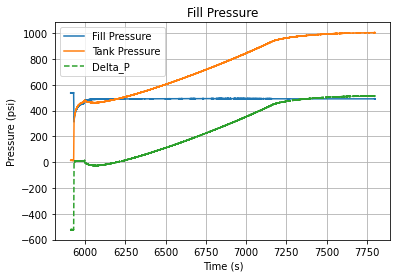

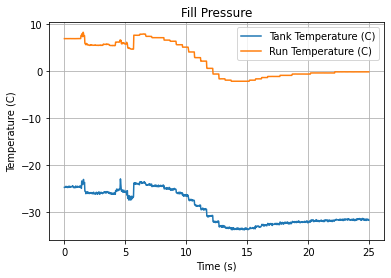

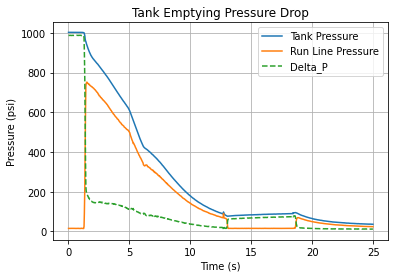

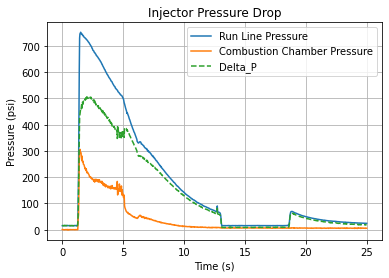

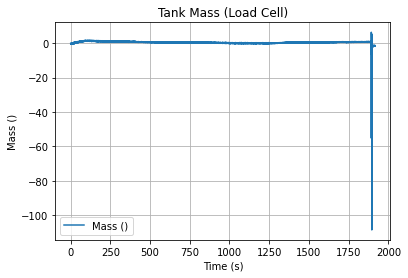

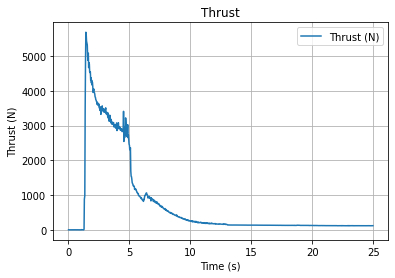

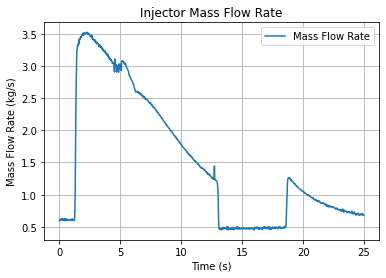

Report generated successfully. You can find it in 'report.tex'.


In [242]:
# Inputs
file_name = 'HOTFIRE2.7.txt'
title = 'HotFire 2.7'
author = 'Propulsion Subteam - McGill Rocket Team'
date = '2023/03/11'
ambient_temp = 5
paraffin_fuel_mass = 1.71
diptube_length = 0.366
discharge_coeff = 0.65
hole_diameter = 2 # mm
num_holes = 22
abstract_text = 'The purpose of this hotfire was to validate engine performance and whether the engine can be fired twice in one day. Initial run tank pressure of ... Peak pre-injector pressure of ... Peak combustion chamber pressure ... Estimated nitrous mass ... The peak thrust was ... with a total impulse of ... The mass flow rate was...'
analysis_text = 'Specific analysis of hotfire data to determine whether the specific goal was met'
conclusions_text = 'Here you briefly summarize your findings and next steps...'

# Extract Data
time_zeroed, time_zeroed_fill, time_zeroed_full, p_tank_fill_range, p_fill_range, p_tank_range, p_run_range, p_cc_new_range, tank_temp_range, run_temp_range, delta_p_tank_run, delta_p_run_cc, delta_p_tank_fill, thrust_range, mass_range, mass_flow_rate, fill_time, peak_run_pressure, peak_cc_pressure, peak_tank_pressure, burn_time, peak_thrust, total_impulse, peak_mass_flow_rate, avg_mass_flow_rate, m_liq, m_gas = extract_data(file_name, ambient_temp, diptube_length, discharge_coeff, hole_diameter, num_holes)

# Generate the plots
generate_plots(file_name, time_zeroed, time_zeroed_fill, time_zeroed_full, p_tank_fill_range, p_fill_range, p_tank_range, p_run_range, p_cc_new_range, tank_temp_range, run_temp_range, delta_p_tank_run, delta_p_run_cc, delta_p_tank_fill, thrust_range, mass_range, mass_flow_rate)

# Generate the latex report
generate_report('hotfire_template.tex', title, author, date, abstract_text, analysis_text, conclusions_text, ambient_temp, paraffin_fuel_mass, fill_time, peak_run_pressure, peak_cc_pressure, peak_tank_pressure, burn_time, peak_thrust, total_impulse, peak_mass_flow_rate, avg_mass_flow_rate, m_liq, m_gas)